In [1]:
import quadrotor
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
# %matplotlib inline
# %matplotlib widget
import IPython
from scipy.linalg import block_diag
from scipy.sparse import csr_matrix
from typing import Tuple
from qpsolvers import Problem, solve_problem

def controller(x,t):
    return np.zeros(2)

# x_init = np.array([0., 0., 0., 0., 0., 0.])
# horizon_length = 10
# t, state, u = quadrotor.simulate(x_init, controller, horizon_length, disturbance=True)



In [2]:
class Optimization:
    def __init__(self, m, l, I, dt, g, xdim, udim):
        self.m = m
        self.l = l
        self.I = I
        self.dt = dt
        self.g = g
        self.xdim = xdim
        self.udim = udim

    def quadrotor_dynamics(self, x_init, y, N=100):
        nvar = self.xdim + self.udim
        # Print the shapes
        # print(f"Total shape of y: {y.shape}")
        # print(f"Total shape of x_init: {x_init.shape}")
        y = np.asarray(y).flatten()
        x_init = np.asarray(x_init).flatten()

        # Define the placeholders for A and b
        A = np.zeros((6 * N, nvar * N))
        b = np.zeros(6 * N)

        # Define the initial state constraints
        A[:6, :] = np.eye(6, nvar * N)
        b[:6] = x_init - y[:6]

        # Define the constraints for the rest of the time steps
        for t in range(N-1):
            # Propogate the indices
            i = t * nvar
            n = i
            n1 = i + nvar

            # Assign the variables at time step t
            px = y[n]
            vx = y[n + 1]
            py = y[n + 2]
            vy = y[n + 3]
            theta = y[n + 4]
            omega = y[n + 5]
            u1 = y[n + 6]
            u2 = y[n + 7]

            # Assign the variables at time step t+1
            px_1 = y[n1]
            vx_1 = y[n1 + 1]
            py_1 = y[n1 + 2]
            vy_1 = y[n1 + 3]
            theta_1 = y[n1 + 4]
            omega_1 = y[n1 + 5]

            # Position x constraint
            A[6 * (t+1), n] = 1
            A[6 * (t+1), n + 1] = self.dt
            A[6 * (t+1), n1] = -1
            b[6 * (t+1)] = px + (self.dt * vx) - px_1

            # Velocity x constraint
            A[6 * (t+1) + 1, n + 1] = 1
            A[6 * (t+1) + 1, n + 4] = -self.dt * ((u1 + u2) * np.cos(theta) / self.m)
            A[6 * (t+1) + 1, n + 6] = -self.dt * (np.sin(theta) / self.m)
            A[6 * (t+1) + 1, n + 7] = -self.dt * (np.sin(theta) / self.m)
            A[6 * (t+1) + 1, n1 + 1] = -1
            b[6 * (t+1) + 1] = vx - (self.dt * (u1 + u2) * np.sin(theta) / self.m) - vx_1

            # Position y constraint
            A[6 * (t+1) + 2, n + 2] = 1
            A[6 * (t+1) + 2, n + 3] = self.dt
            A[6 * (t+1) + 2, n1 + 2] = -1
            b[6 * (t+1) + 2] = py + self.dt * vy - py_1
            
            # Velocity y constraint
            A[6 * (t+1) + 3, n + 3] = 1
            A[6 * (t+1) + 3, n + 4] = -self.dt * ((u1 + u2) * np.sin(theta) / self.m)
            A[6 * (t+1) + 3, n + 6] = self.dt * (np.cos(theta) / self.m)
            A[6 * (t+1) + 3, n + 7] = self.dt * (np.cos(theta) / self.m)
            A[6 * (t+1) + 3, n1 + 3] = -1
            b[6 * (t+1) + 3] = vy + self.dt * (((u1 + u2) * np.cos(theta) / self.m) - 9.81) - vy_1

            # Angle theta constraint
            A[6 * (t+1) + 4, n + 4] = 1
            A[6 * (t+1) + 4, n + 5] = self.dt
            A[6 * (t+1) + 4, n1 + 4] = -1
            b[6 * (t+1) + 4] = theta + self.dt * omega - theta_1

            # Angular velocity omega constraint
            A[6 * (t+1) + 5, n + 5] = 1
            A[6 * (t+1) + 5, n + 6] = self.dt * self.l / self.I
            A[6 * (t+1) + 5, n + 7] = -self.dt * self.l / self.I
            A[6 * (t+1) + 5, n1 + 5] = -1
            b[6 * (t+1) + 5] = omega + self.dt * self.l * (u1 - u2) / self.I - omega_1

        # # Print shapes of A and b
        # print(f"Shape of A: {A.shape}")
        # print(f"Shape of b: {b.shape}")
        return A, b

    def circle_traj_gen(self, t, N):
        des_x = np.cos(-np.pi/2+ 2*np.pi*t/N)
        des_y = 1 + np.sin(-np.pi/2 + (2*np.pi * t/N))

        if (t <= (N/5)):
            des_theta = 0

        elif ((N/5) <= t <= (2*N/5)):
            des_theta = np.pi/2

        elif ((2*N/5) <= t <= (3*N/5)):
            des_theta = np.pi

        elif ((3*N/5) <= t <= (4*N/5)):
            des_theta = 3 * np.pi/2

        elif ((4*N/5) <= t <= N):
            des_theta = 2 * np.pi
        return des_x, des_y, des_theta
    
    

    def QR_cost(self):
        Q = np.diag([10, 1, 10, 1, 10, 1])
        R = np.diag([0.1, 0.1])

        return Q, R

    def cost_function(self, y, x_init, N, k=0):
        # Number of variables in state and control
        nvar = self.xdim + self.udim
        y = y.flatten()
        x_init = x_init.flatten()
        mini_Q, mini_R = self.QR_cost()

        # Initialize the cost for N states and N-1 controls
        P = block_diag(*([mini_Q, mini_R] * N))
        q = np.zeros((nvar * N))

        # Loop over the horizon
        for t in range(N):
            des_x, des_y, des_theta = self.circle_traj_gen(t=k, N=N)
            k = k + 1
            q[(nvar * t):(nvar * t + nvar)] = np.concatenate(((-(np.array([[des_x], [0], [des_y], [0], [des_theta], [0]]).T @ mini_Q)).flatten(), [0, 0]))

        q = q.reshape(-1, 1).flatten()
        cost = 0.5 * (y.T @ P @ y) + (q.T @ y)

        # Sanity Check for the shapes
        # print(f"Shape of P: {P.shape}")
        # print(f"Shape of q: {q.shape}")
        # print(f"Shape of y: {y.shape}")
        # print(f"Shape of x_init: {x_init.shape}")

        return cost

    def grad_cost(self, x_init, y, N, k=0):
        # Number of variables in state and control
        nvar = self.xdim + self.udim
        x_init = x_init.flatten()
        y = y.flatten()

        mini_Q, mini_R = self.QR_cost()

        P = block_diag(*([mini_Q, mini_R] * N))
        q = np.zeros((nvar * N))

        # # Print the shapes of P and q
        # print(f"Shape of P: {P.shape}")
        # print(f"Shape of q: {q.shape}")

        for t in range(N):
            des_x, des_y, des_theta = self.circle_traj_gen(t=k, N=N)
            k = k + 1
            q[(nvar * t):(nvar * t + nvar)] = np.concatenate(((-(np.array([[des_x], [0], [des_y], [0], [des_theta], [0]]).T @ mini_Q)).flatten(), [0, 0]))

        grad_f = P @ y + q

        return grad_f


        
    

    def hess_cost(self, N):
        mini_Q, mini_R = self.QR_cost()

        cost_hess = block_diag(*([mini_Q, mini_R] * N))
        # assert cost_hess.shape[0] == cost_hess.shape[1]

        return cost_hess
    

    def state_constraints(self, y: np.ndarray, N: int = 500) -> Tuple[np.ndarray, np.ndarray]:
        
        nvar = self.udim + self.xdim

        y = np.asarray(y).flatten()

        mini_G = np.array([
            [0, 0, 1, 0, 0, 0, 0, 0], 
            [0, 0, -1, 0, 0, 0, 0, 0],  
            [0, 0, 0, 0, 0, 0, 1, 0],  
            [0, 0, 0, 0, 0, 0, -1, 0],  
            [0, 0, 0, 0, 0, 0, 0, 1],  
            [0, 0, 0, 0, 0, 0, 0, -1]   
        ])

        
        G = block_diag(*([mini_G] * N))

        h = np.zeros(6 * N)

        for i in range(N):
            u_1 = y[(i * nvar) + 6]
            u_2 = y[(i * nvar) + 7]

            h[(6 * i)] = 2 - y[(i * nvar) + 2]
            h[(6 * i) + 1] = y[(i * nvar) + 2]
            h[(6 * i) + 2] = 10 - u_1
            h[(6 * i) + 3] = u_1
            h[(6 * i) + 4] = 10 - u_2
            h[(6 * i) + 5] = u_2

        # # Print the shapes of G and h
        # print(f"Shape of G: {G.shape}")
        # print(f"Shape of h: {h.shape}")
        
            

        return G, h


    def KKT_Solver(self, x_init, y, N, k=0):
        A, b = self.quadrotor_dynamics(x_init, y, N)
        G, h = self.state_constraints(y, N)
        
        kkt_problem = Problem(P = csr_matrix(self.hess_cost(N)),
                              q = self.grad_cost(x_init, y, N, k=k), 
                              A = csr_matrix(A), 
                              b = -b, 
                              G = csr_matrix(G), 
                              h = h)
        kkt_sol = solve_problem(problem=kkt_problem, solver="cvxopt")
            
        return kkt_sol
    

    def constaint_violation(self, x_init, y, N):
        nvar = self.xdim + self.udim
        y = np.asarray(y).flatten()
        x_init = np.asarray(x_init).flatten()

        A_prime, b_prime = self.quadrotor_dynamics(x_init, y, N)
        total_violation = np.sum(np.abs(b_prime))
        inequality_violation = 0

        for i in range(N):
            u1 = y[(nvar * i) + 6]
            u2 = y[(nvar * i) + 7]
            if u1 > 10:
                total_violation += np.abs(u1 - 10)
            elif u1 < 0:
                total_violation += np.abs(u1)

            if u2 > 10:
                total_violation += np.abs(u2 - 10)
            elif u2 < 0:
                total_violation += np.abs(u2)

            if y[(nvar * i) + 2] < 0:
                total_violation += np.abs(y[(nvar * i) + 2])

        return total_violation + inequality_violation
    


    def line_search(self, x_init, est_y, N, alpha=1.0, rho=0.5, tol=1e-4, iterations=1000, k = 0):
        nvar = self.udim + self.xdim

        est_y = np.asarray(est_y).flatten()
        x_init = np.asarray(x_init).flatten()

        # Initialize variables for tracking progress
        least_violation = np.inf
        optimal_cost = np.inf
        cost_list = []
        alpha_list = []
        violation_list = []

        for i in range(iterations):
            smallville = False

            sol = self.KKT_Solver(x_init, est_y, N, k=k)
            pk = sol.x
            while ((self.cost_function(y=(est_y + (alpha * pk)), x_init=x_init, N=N, k=k) >= optimal_cost) and (self.constaint_violation(x_init, est_y + (alpha * pk), N) >= least_violation)):
                alpha = rho * alpha
                if alpha < 1e-6:
                    smallville = True
                    break

            if smallville:
                break

            least_violation = self.constaint_violation(x_init, est_y + (alpha * pk), N)
            optimal_cost = self.cost_function(y=(est_y + (alpha * pk)), x_init=x_init, N=N, k=k)
            alpha_list.append(alpha)
            cost_list.append(optimal_cost)
            violation_list.append(least_violation)
            # Update est_y
            est_y = est_y + (alpha * pk)

            # Termination condition
            if least_violation < tol and i != 0:
                break

        est_y = est_y.reshape(-1, nvar)
        x = est_y[:, :self.xdim].T
        u = est_y[:, self.xdim:].T

        print(f"Convergence reached at iteration {i+1}.")

        return x, u
    

    def controller(self, x_init: np.ndarray, k: int, verbose: bool = True):
        # Define the prediction horizon
        TIME_STEPS = 50
        # print(x_init)
        # Initialize guess for state and control trajectories
        est_y = np.zeros((self.udim + self.xdim) * TIME_STEPS)
        # Set the initial state in the guess
        est_y[:self.xdim] = x_init

        try:
            x, u = self.line_search(x_init=x_init, est_y=est_y, N=TIME_STEPS, alpha=1.0, rho=0.5, tol=1e-4, k=k)

            # Log optimization results if verbose is enabled
            if verbose:
                next_state = quadrotor.next_state(
                    x[:, 0].flatten(), u[:, 0].flatten())
                print(
                    f"For k = {k}\n"
                    f"    x_init  = {x[:, 0].flatten()}\n"
                    f"    u = {u[:, 0].flatten()}\n"
                    f"    Next State = {next_state}"
                )

        except ValueError as e:
            # Handle optimization failure
            print(f"Optimization failed at time {k * quadrotor.DT}: {e}")

        # Perform garbage collection
        # gc.collect()

        # Return the control input for the first time step
        return u[:, 0].flatten()
    
    def mpc_states(self, x_init: np.ndarray) -> Tuple:
        horizon_length = 300
        t, state, u = quadrotor.simulate(
                x_init,  # Initial state
                self.controller,  # Controller function
                horizon_length,  # Simulation length
                disturbance=True  # Enable disturbances
                )
        return t, state, u
    



In [3]:
N = 100
x_init = np.zeros(6)
est_y = np.zeros(8*N)
rho = 0.5
tol = 1e-4
alpha = 1
opt = Optimization(quadrotor.MASS, quadrotor.LENGTH, quadrotor.INERTIA, quadrotor.DT, quadrotor.GRAVITY_CONSTANT, quadrotor.DIM_STATE, quadrotor.DIM_CONTROL)
x, u = opt.line_search(x_init=x_init, est_y=est_y, N=N, alpha=alpha, rho=rho, tol=tol, iterations=1000)


Convergence reached at iteration 25.


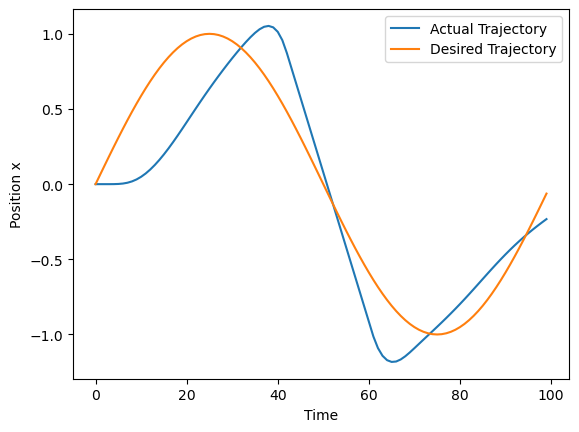

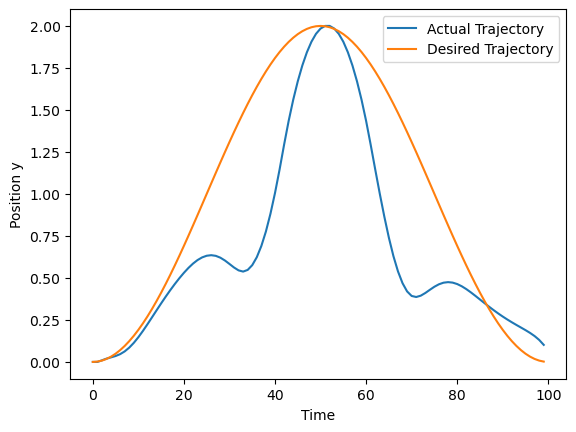

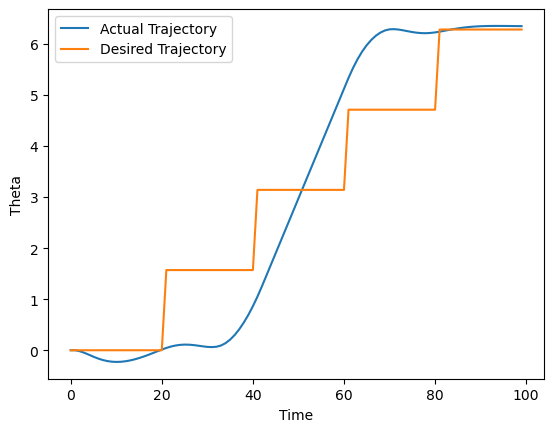

In [4]:
traj = Optimization(quadrotor.MASS, quadrotor.LENGTH, quadrotor.INERTIA, quadrotor.DT, quadrotor.GRAVITY_CONSTANT, quadrotor.DIM_STATE, quadrotor.DIM_CONTROL)
# Store the desired trajectory
x_traj = np.zeros(N)
y_traj = np.zeros(N)
theta_traj = np.zeros(N)

for i in range(N):
    des_x, des_y, des_theta = traj.circle_traj_gen(t=i, N=N)
    x_traj[i] = des_x
    y_traj[i] = des_y
    theta_traj[i] = des_theta



# Plot the desired and coordinates
plt.figure()
plt.plot(x[0, :], label="Actual Trajectory")
plt.plot(x_traj, label="Desired Trajectory")
plt.xlabel("Time")
plt.ylabel("Position x")
plt.legend()
plt.show()  

plt.figure()
plt.plot(x[2, :], label="Actual Trajectory")
plt.plot(y_traj, label="Desired Trajectory")
plt.xlabel("Time")
plt.ylabel("Position y")
plt.legend()
plt.show()

plt.figure()
plt.plot(x[4, :], label="Actual Trajectory")
plt.plot(theta_traj, label="Desired Trajectory")
plt.xlabel("Time")
plt.ylabel("Theta")
plt.legend()
plt.show()


In [5]:
# quadrotor.animate_robot(x,u)

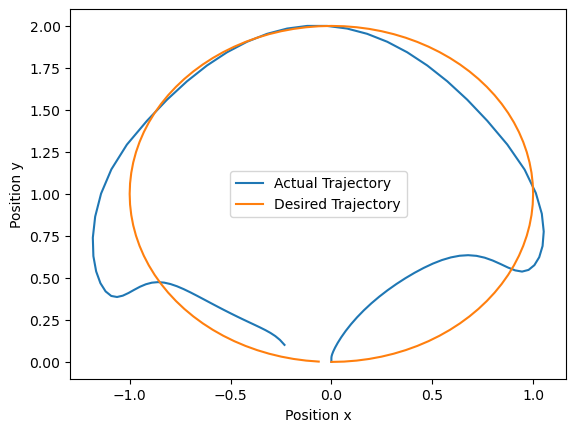

In [6]:
traj = Optimization(quadrotor.MASS, quadrotor.LENGTH, quadrotor.INERTIA, quadrotor.DT, quadrotor.GRAVITY_CONSTANT, quadrotor.DIM_STATE, quadrotor.DIM_CONTROL)
# Store the desired trajectory
x_traj = np.zeros(N)
y_traj = np.zeros(N)
theta_traj = np.zeros(N)

for i in range(N):
    des_x, des_y, des_theta = traj.circle_traj_gen(t=i, N=N)
    x_traj[i] = des_x
    y_traj[i] = des_y
    theta_traj[i] = des_theta



# Plot the trajectory in 2D
plt.figure()
plt.plot(x[0, :], x[2, :], label="Actual Trajectory")
plt.plot(x_traj, y_traj, label="Desired Trajectory")
plt.xlabel("Position x")
plt.ylabel("Position y")
plt.legend()
plt.show()



In [7]:
# import numpy as np
# import gc

# controller = opt.controller(x_init, k_init=0, verbose=True)

# print(f"Control input at k = 0: {controller}")

t, state, u = opt.mpc_states(x_init=x_init)
# # Simulation parameters
# horizon_length = 300  # Total simulation horizon length

# # Simulate the quadrotor's trajectory
# t, state, u = quadrotor.simulate(
#     x_init,  # Initial state
#     opt.controller(x_init=x_init,k_init=0,verbose=True),  # Controller function
#     horizon_length,  # Simulation length
#     disturbance=True  # Enable disturbances
# )

# Animate the quadrotor's trajectory
# quadrotor.animate_robot(state, u)

Convergence reached at iteration 10.
For k = 0
    x_init  = [-1.48637669e-31  1.31778517e-17  7.69295314e-22  6.70127781e-13
  5.11754661e-18  1.52184733e-17]
    u = [1.67695897e-11 9.86732394e+00]
    Next State = [ 5.27114067e-19  9.13813247e-18  2.68051120e-14  3.96985915e-01
  5.72628554e-18 -5.92039436e-01]
Convergence reached at iteration 7.
For k = 1
    x_init  = [ 1.35895745e-19 -9.32727711e-01 -6.27414288e-23  1.34406296e+00
 -1.07315485e-17 -1.02144695e+00]
    u = [5.39604149e-12 1.40909377e+00]
    Next State = [-0.03730911 -0.93272771  0.05376252  1.06439046 -0.04085788 -1.10599257]


UnboundLocalError: local variable 'des_theta' referenced before assignment

In [ ]:
quadrotor.animate_robot(state, u)